In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Datasets/brain_mri.zip' -d '/content/tmp'

In [1]:
import os
import tensorflow as tf
import numpy as np
import imgaug as aug
from pathlib import Path
from glob import glob
from enum import Enum
import cv2
from threading import Thread
import time
import random
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import numpy as np
from sklearn.svm import SVC

from sklearn.ensemble import  ExtraTreesClassifier

from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Activation, Input, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [5]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(42)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(42)

# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(42)

In [6]:
DATASET_PATH = '/content/tmp/brain_mri'
RESIZED_IMAGE_SIZE = 224

class DatasetType(Enum):
    TRAIN = 'Training'
    TEST = 'Testing'
    
class DataType(Enum):
    no_tumor = 0
    glioma_tumor = 1
    meningioma_tumor = 2
    pituitary_tumor = 3

class DataLabel(Enum):
    NO_TUMOR = 0
    TUMOR = 1

class ImageType(Enum):
    ORIGINAL = 'original'
    AUGMENTED = 'augmented'

In [7]:
class BrainMRIDataset ():

    def __init__ (self, dataset_type=DatasetType.TRAIN, num_samples=None, original_img_probability=0.1):
        
        self.dataset_type = dataset_type
        self.original_img_probability = original_img_probability
        self.num_samples = num_samples

        x_no_tumor_path = self.__get_image_path (dataset_type, DataType.no_tumor)
        x_glioma_tumor_path = self.__get_image_path (dataset_type, DataType.glioma_tumor)
        x_meningioma_tumor_path = self.__get_image_path (dataset_type, DataType.meningioma_tumor)
        x_pituitary_tumor_path = self.__get_image_path (dataset_type, DataType.pituitary_tumor)
        x_tumor_path = x_no_tumor_path + x_glioma_tumor_path + x_meningioma_tumor_path + x_pituitary_tumor_path

        self.y_data = [ DataType.no_tumor.value ] * len (x_no_tumor_path) + [ DataType.glioma_tumor.value ] * len (x_glioma_tumor_path) + [ DataType.meningioma_tumor.value ] * len (x_meningioma_tumor_path) + [ DataType.pituitary_tumor.value ] * len (x_pituitary_tumor_path)
        self.y_data = to_categorical (self.y_data, num_classes=4)

        del x_no_tumor_path
        del x_glioma_tumor_path
        del x_meningioma_tumor_path
        del x_pituitary_tumor_path

        start_time = time.time()
        self.x_data = []
        self.__load_images (x_tumor_path, self.x_data)

        del x_tumor_path

        self.x_data = np.expand_dims(self.x_data, axis=-1)
        
        print (f'Total time for loading {str(dataset_type.value)} images: {time.time() - start_time}')
        
    
    def get_data (self):
        return self.x_data, self.y_data
    

    def __get_image_path (self, dataset_type: DatasetType, data_type: DataType):
        return glob(DATASET_PATH + '/' + str(dataset_type.value) + '/' + str(data_type.name) + '/*.jpg', recursive=False)
    
    
    def __read_preprocessed_image (self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        img = img.astype(np.float32)/255.
        return img
    
    
    def __load_images (self, img_paths, result):
        for img_path in img_paths:
            try:
                result.append (self.__read_preprocessed_image(img_path))
            except Exception as e:
                print (e)

    
    def __getitem__ (self, index):
        return self.x_data[index], self.y_data[index]
        

    def __len__ (self):
        return len (self.y_data)

In [211]:
X_train, y_train = BrainMRIDataset (DatasetType.TRAIN).get_data ()
X_train = np.repeat(X_train[...], 3, -1)
print ('Train dataset size:', len(X_train))

X_test, y_test = BrainMRIDataset (DatasetType.TEST).get_data ()
X_test = np.repeat(X_test[...], 3, -1)
print ('Test dataset size:', len(X_test))

Total time for loading Training images: 5.673284292221069
Train dataset size: 2870
Total time for loading Testing images: 0.5528216361999512
Test dataset size: 394


In [212]:
print('Train data shape:', X_train.shape)
print('Train labels size:', y_train.shape)

Train data shape: (2870, 196, 196, 3)
Train labels size: (2870, 4)


In [213]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)

In [214]:
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)

In [215]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


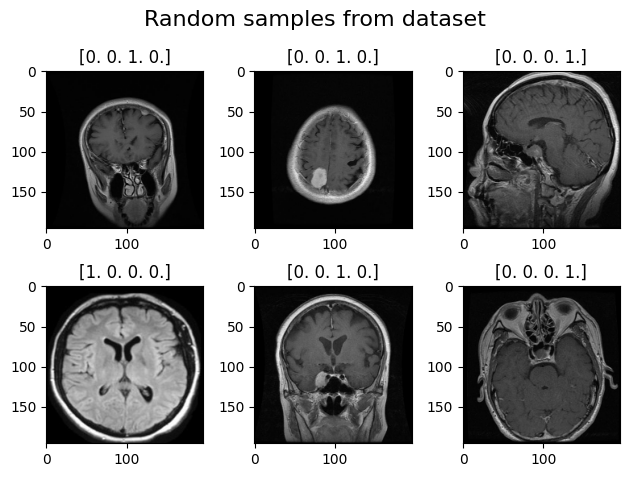

In [216]:
plt.rcParams.update(plt.rcParamsDefault)
for i in range (6):
    plt.suptitle("Random samples from dataset", fontsize=16)
    ax = plt.subplot (2, 3, i+1)
    plt.imshow (X_train[i], cmap='gray')
    ax.set_title(y_train[i])
    plt.tight_layout()
plt.show ()

In [217]:
from tensorflow.keras.applications import MobileNet

In [204]:
MODEL_NAME = 'CompactMedNet'
def create_model ():

    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE, 1)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    return model

model = create_model ()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 196, 196, 16)      160       
                                                                 
 conv2d_51 (Conv2D)          (None, 196, 196, 16)      2320      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 98, 98, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 98, 98, 32)        4640      
                                                                 
 conv2d_53 (Conv2D)          (None, 98, 98, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                 

In [218]:
MODEL_NAME = 'MobileNet'
def create_model ():

    pretrained_model=MobileNet(weights='imagenet', include_top=False,input_shape=(RESIZED_IMAGE_SIZE,RESIZED_IMAGE_SIZE,3))
    
    #train the model
    tf.random.set_seed(45)
    model = pretrained_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(64,activation='elu',kernel_initializer='GlorotNormal')(model)
    model = tf.keras.layers.Dropout(rate=0.2)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=pretrained_model.input, outputs = model)

    return model

model = create_model ()
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 98, 98, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 98, 98, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 98, 98, 32)       128       
 ation)                                                   

In [220]:
model.compile(optimizer = Adam(
                learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
                epsilon=1e-08), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [221]:
#weight_path="/content/tmp/{}.best.hdf5".format(MODEL_NAME)
weight_path="content/tmp/{}.best.hdf5".format(MODEL_NAME)

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

early = EarlyStopping(restore_best_weights=True,
                      patience=9)
callbacks_list = [checkpoint, early]

In [222]:
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs = 100,
                    shuffle=True,
                    verbose=1,
                    validation_split=0.15,
                    callbacks=callbacks_list)

Epoch 1/100
129/130 [============================>.] - ETA: 0s - loss: 1.0893 - accuracy: 0.5867
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to content/tmp/cnn9.best.hdf5
130/130 [==============================] - 23s 60ms/step - loss: 1.0871 - accuracy: 0.5880 - val_loss: 0.8440 - val_accuracy: 0.6667
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8365
Epoch 2: val_accuracy improved from 0.66667 to 0.76503, saving model to content/tmp/cnn9.best.hdf5
130/130 [==============================] - 7s 51ms/step - loss: 0.4608 - accuracy: 0.8365 - val_loss: 0.6084 - val_accuracy: 0.7650
Epoch 3/100
129/130 [============================>.] - ETA: 0s - loss: 0.3168 - accuracy: 0.8895
Epoch 3: val_accuracy improved from 0.76503 to 0.84153, saving model to content/tmp/cnn9.best.hdf5
130/130 [==============================] - 7s 53ms/step - loss: 0.3189 - accuracy: 0.8886 - val_loss: 0.4254 - val_accuracy: 0.8415
Epoch 4/100
129/13

14/14 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.94        65
           1       0.92      0.99      0.95       115
           2       0.91      0.90      0.91       125
           3       0.98      0.96      0.97       126

    accuracy                           0.94       431
   macro avg       0.95      0.94      0.94       431
weighted avg       0.94      0.94      0.94       431



<Figure size 640x480 with 0 Axes>

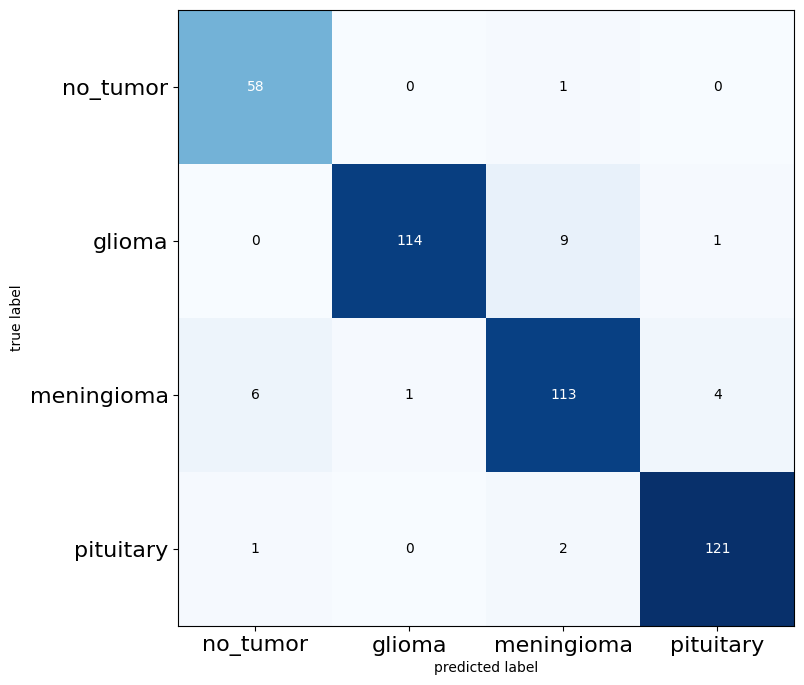

In [223]:
trained_model = create_model ()
trained_model.load_weights ('content/tmp/' + MODEL_NAME + '.best.hdf5')
y_pred = trained_model.predict(X_test)

print(classification_report(np.argmax(y_pred, axis = 1),np.argmax(y_test, axis = 1)))

cm  = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['no_tumor', 'glioma', 'meningioma', 'pituitary'], fontsize=16)
plt.yticks(range(4), ['no_tumor', 'glioma', 'meningioma', 'pituitary'], fontsize=16)
plt.show()

In [177]:
feature_extractor = create_model ()
feature_extractor.load_weights ('content/tmp/' + MODEL_NAME + '.best.hdf5')
feature_extractor.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 98, 98, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 98, 98, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 98, 98, 32)       128       
 ation)                                                    

In [180]:
# Get input
new_input = feature_extractor.input
# Find the layer to connect
hidden_layer = feature_extractor.layers[-4].output
# Connect a new layer on it
#new_output = Dense(3) (hidden_layer)
# Build a new model
model2 = Model(new_input, hidden_layer)
model2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 98, 98, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 98, 98, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 98, 98, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 98, 98, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 98, 98, 32)       128       
 ation)                                                    

In [181]:
features_train = model2.predict(X_train)
features_test = model2.predict(X_test)

14/14 [==============================] - 0s 21ms/step


In [184]:
clf = SVC(kernel="linear", C=0.025)
clf.fit (features_train, np.argmax(y_train, axis = 1))

clf_prediction = clf.predict(features_test)
print(clf_prediction[:1])

print(classification_report(clf_prediction, np.argmax(y_test, axis = 1)))

[1]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        63
           1       0.97      0.98      0.98       122
           2       0.92      0.95      0.93       120
           3       0.98      0.97      0.98       126

    accuracy                           0.96       431
   macro avg       0.96      0.96      0.96       431
weighted avg       0.96      0.96      0.96       431



<Figure size 640x480 with 0 Axes>

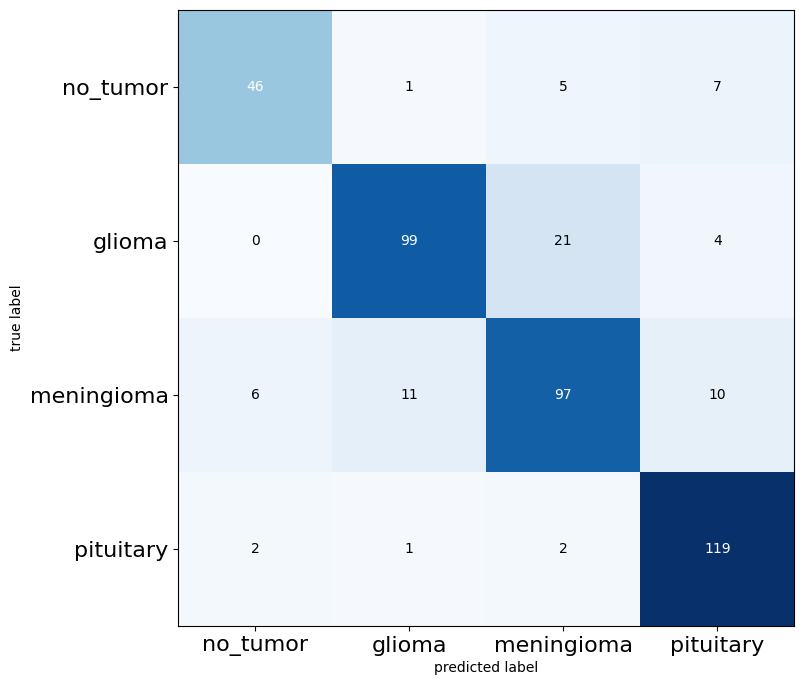

In [34]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), clf_prediction)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['no_tumor', 'glioma', 'meningioma', 'pituitary'], fontsize=16)
plt.yticks(range(4), ['no_tumor', 'glioma', 'meningioma', 'pituitary'], fontsize=16)
plt.show()